In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
from functions.evolutionaryalgo import quadratic_loss_function
from functions.inequality import gini, lorenz_curve
from distribution_model import *
import statsmodels.api as sm
from SALib.sample import latin
from matplotlib import style
from collections import OrderedDict
from functions.indirect_calibration import distr_model_performance
import seaborn as sns
import scipy.stats as stats
import scipy

In [2]:
style.use('ggplot')

In [3]:
NRUNS = 1

## Get parameters from calibration

In [4]:
pickle_in = open("nm_calibration_result.pickle","rb")
calibration_result = pickle.load(pickle_in)
print(calibration_result[0]['xopt'])
print(['trader_sample_size', 'std_noise', 'w_fundamentalists', 'w_momentum',
                      'init_stocks', 'base_risk_aversion', 'horizon'])

[ 26.5180976    0.20813277  47.61067793  55.01524439  17.8769443
  13.04209231  26.97721807]
['trader_sample_size', 'std_noise', 'w_fundamentalists', 'w_momentum', 'init_stocks', 'base_risk_aversion', 'horizon']


In [5]:
# convert relevant parameters to integers
integer_var_locations = [0, 4, 6]
new_input_params = []
for idx, par in enumerate(calibration_result[0]['xopt']):
    if idx in integer_var_locations:
        new_input_params.append(int(par))
    else:
        new_input_params.append(par.item())

In [6]:
uncertain_parameters = dict(zip(['trader_sample_size', 'std_noise', 'w_fundamentalists', 'w_momentum',
                      'init_stocks', 'base_risk_aversion', 'horizon'], new_input_params))
params = {"ticks": 10235, "fundamental_value": 166, 'n_traders': 1000, 'std_fundamental': 0.0530163128919286,
              'spread_max': 0.004087, "w_random": 1.0}
params.update(uncertain_parameters)
params

{'base_risk_aversion': 13.04209230587413,
 'fundamental_value': 166,
 'horizon': 26,
 'init_stocks': 17,
 'n_traders': 1000,
 'spread_max': 0.004087,
 'std_fundamental': 0.0530163128919286,
 'std_noise': 0.20813277184315787,
 'ticks': 10235,
 'trader_sample_size': 26,
 'w_fundamentalists': 47.61067793142201,
 'w_momentum': 55.01524438775738,
 'w_random': 1.0}

In [11]:
params['w_fundamentalists'] = 5.0
params

{'base_risk_aversion': 13.04209230587413,
 'fundamental_value': 166,
 'horizon': 26,
 'init_stocks': 17,
 'n_traders': 1000,
 'spread_max': 0.004087,
 'std_fundamental': 0.0530163128919286,
 'std_noise': 0.20813277184315787,
 'ticks': 10235,
 'trader_sample_size': 26,
 'w_fundamentalists': 5.0,
 'w_momentum': 55.01524438775738,
 'w_random': 1.0}

## Run model

In [12]:
trdrs = []
obs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    obs.append(orderbook)

('Start of simulation ', 0)


# Analyse dynamics

In [15]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(obs, burn_in_period=0)

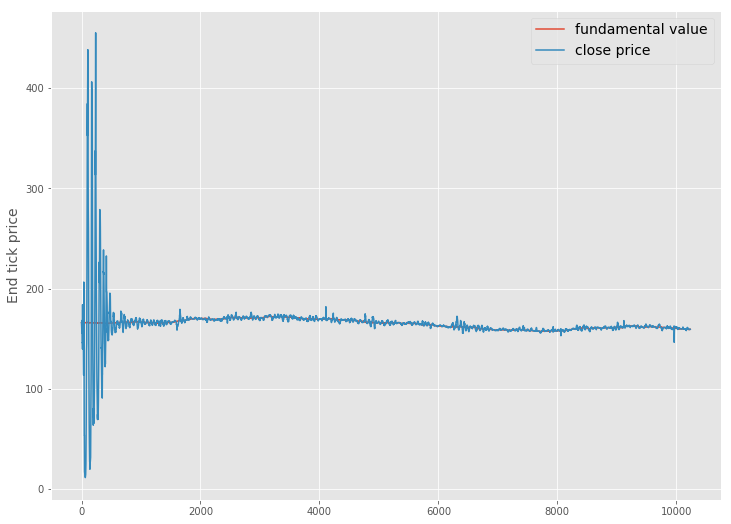

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,9))

ax1.plot(mc_fundamentals.index, mc_fundamentals[0], label='fundamental value')
ax1.plot(mc_prices.index, mc_prices[0], label='close price')

ax1.set_ylabel('End tick price', fontsize='14')
ax1.legend(loc='best', fontsize='14')

#fig.savefig('behavioural_hypothesis.png')

## Distributional dynamics

I am interested in the following distributions:

* wealth
* stocks
* money

I am interested in the following properties of the wealth distribution

1. Gini coefficient & Lorenz curve
2. Skew? 
3. Kurtosis? 
4. Concentration curves? 

### Money

In [17]:
# at the end of the simulation
money_holdings = np.array([x.var.money[-1] for x in trdrs[0]])

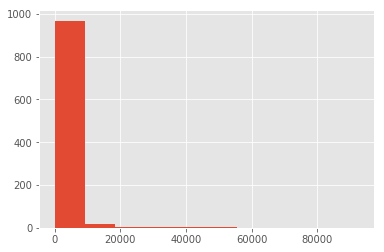

In [18]:
pd.Series(np.sort(money_holdings)).hist()

In [19]:
gini(money_holdings)

0.83864470331399465

Gini Evolution over time

In [20]:
money_gini_over_time = []
for t in range(params['ticks']):
    #print(t)
    money = np.array([x.var.money[t] for x in trdrs[0]])
    money_gini_over_time.append(gini(money))

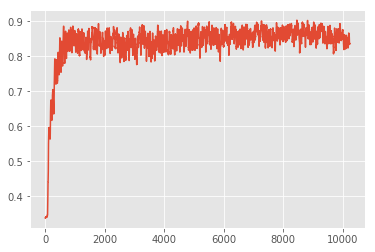

In [21]:
pd.Series(money_gini_over_time).plot()

### The distribution of Wealth
Wealth is measured as trader money + trader stock * price 

In [41]:
money = np.array([x.var.money[-1] for x in trdrs[0]])
stocks = np.array([x.var.stocks[-1] for x in trdrs[0]])
wealth = money + (stocks * mc_prices[0].iloc[-1])
#n, bins, patches = plt.hist(wealth, 50, density=True, alpha=0.75)

### Descriptives

In [49]:
pd.Series(wealth).describe()

count      1000.000000
mean       2657.871782
std       12281.057679
min          44.040314
25%         275.262838
50%         473.021942
75%        1042.225814
max      234396.263010
dtype: float64

Skewness and Kurtosis

In [51]:
print('Skewness is ', pd.Series(wealth).skew())
print('Kurtosis is ', pd.Series(wealth).kurtosis())

('Skewness is ', 11.473920970930513)
('Kurtosis is ', 169.83931409848464)


### Ratios

#### Palma ratio
It is the ratio of national income shares of the top 10 per cent of
households to the bottom 40 per cent.

In [75]:
share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
print('Share top 10 is ', share_top_10)
share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
print('Share bottom 40 is ', share_bottom_40)

('Share top 10 is ', 0.79712705852465249)
('Share bottom 40 is ', 0.035737666867353954)


In [76]:
palma = share_top_10 / share_bottom_40
print('Palma ratio is ', palma)

('Palma ratio is ', 22.304955202680596)


### 20/20 ratio
Compares the ratio of the average income of the richest 20
per cent of the population to the average income of the poorest
20 per cent of the population.

In [81]:
share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
print('Average wealth top 20 is ', share_top_20)
share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
print('Average wealth bottom 20 is ', share_bottom_20)
twenty_twenty = share_top_20 / share_bottom_20
print('20/20 ratio is ', twenty_twenty)

('Average wealth top 20 is ', 11447.896015313936)
('Average wealth bottom 20 is ', 176.0664692447906)
('20/20 ratio is ', 65.020307753190508)


### Cumulative distribution

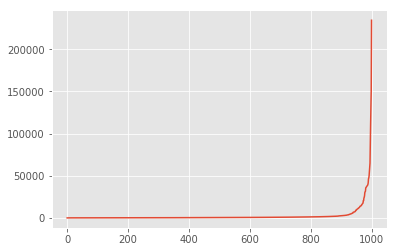

In [40]:
pd.Series(np.sort(wealth)).plot()

## Lorenz curve and Gini coefficient 

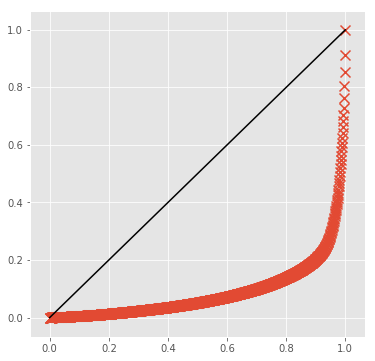

In [38]:
lorenz_curve(np.sort(wealth))

In [42]:
wealth_gini_over_time = []
for t in range(params['ticks']):
    #print(t)
    money = np.array([x.var.money[t] for x in trdrs[0]])
    stocks = np.array([x.var.stocks[t] for x in trdrs[0]])
    wealth = money + (stocks * obs[0].tick_close_price[t])
    wealth_gini_over_time.append(gini(wealth))

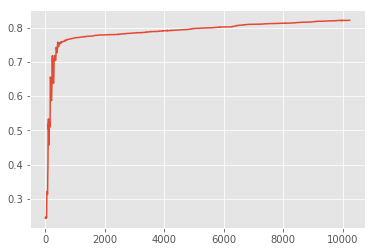

In [43]:
pd.Series(wealth_gini_over_time).plot()

## Indirect Calibration
To calibrate the model parameters, I minimize the following quadtratic loss function: 

$J = J(m) = (m^{sim} - m^{emp})' W (m^{sim} - m^{emp}) $

The first term is the transpose of the difference between simulated and actual moments. The second term is the Idendity matrix. The third term is the difference between simulated and empirical moments. 

The next step is to determine the parameter bounds. Table 1 provides an overview.

| Parameter | Values (start, stop, step) |
| -------------| ------------|
| **trader_sample_size**      | 1, 30, 10      |
| **std_noise**       | 0.05, 0.30, 0.01      |
| **w_fundamentalists**       | 0.0, 100.0., 1.0      |
| **w_momentum**       | 0.0, 100.0, 1.0      |
| **horizon_max**       | 9, 30, 1      |
| **base_risk_aversion**       | 0.5, 10.0, 0.5       |
| **init_stocks**       | 10, 100, 10      |
*Table 1 Parameter bounds*

In [8]:
problem = {
  'num_vars': 7,
  'names': ['trader_sample_size', 'std_noise', 
            'w_fundamentalists', 'w_momentum',
            'init_stocks', 'base_risk_aversion',
           'horizon'],
  'bounds': [[1, 30], [0.05, 0.30], 
             [0.0, 100.0], [0.0, 100.0], 
             [1, 100], [0.1, 15.0],
             [9, 30]]
}

In [9]:
empirical_moments = np.array([ -9.56201354e-03,  -9.55051841e-02,  -5.52010512e-02,
         3.35217232e-01,   1.24673150e+01,   3.46352635e-01,
         2.72135459e-01,   1.88193342e-01,   1.75876698e-01]) # all moments from Schasfoort 2018 except for the cointegr moment

In [10]:
population_size = 1

In [11]:
latin_hyper_cube = latin.sample(problem=problem, N=population_size)
latin_hyper_cube = latin_hyper_cube.tolist()

Transform some parameters to integers:

In [12]:
for idx, parameters in enumerate(latin_hyper_cube):
    # ints: 0, 4, 6
    latin_hyper_cube[idx][0] = int(latin_hyper_cube[idx][0])
    latin_hyper_cube[idx][4] = int(latin_hyper_cube[idx][4])
    latin_hyper_cube[idx][6] = int(latin_hyper_cube[idx][6])

In [13]:
fixed_parameters = {"ticks": 2235, "fundamental_value": 166,
                    'n_traders': 1000, 'std_fundamental': 0.0530163128919286, 'spread_max': 0.004087, 
                    "w_random": 1.0}

In [27]:
problem['names']

['trader_sample_size',
 'std_noise',
 'w_fundamentalists',
 'w_momentum',
 'init_stocks',
 'base_risk_aversion',
 'horizon']

In [28]:
x0

[29,
 0.12206637944302536,
 52.62661439665646,
 4.268534690074677,
 31,
 7.698685141128926,
 19]

### What I need to optimize model

* init guess = latin hypercube sample 
* list of LB for all parameters
* list of HB for all parameters
* function which takes as input list of parameters and outputs its J-score

In [17]:
x0 = latin_hyper_cube[0]
LB = [x[0] for x in problem['bounds']]
UB = [x[1] for x in problem['bounds']]

# Call optimizer
res = cNM.constrNM(distr_model_performance,x0,LB,UB, maxiter=100, full_output=True)

# Print results
cNM.printDict(res)

TypeError: 'numpy.float64' object cannot be interpreted as an index